In [47]:
import sys
sys.path.append('../')
import graph.random_graph as random_graph
import util.create_population as create_population
import core_nn.pure_fit_model as pure_fit_model

import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

In [219]:
class general_EPIs_dense(torch.nn.Module):
    def __init__(self, contact, psMatrices, crossImmMatrix, Ts, train=False, sampleAsState=False, device="cpu"):
        super(general_EPIs_dense, self).__init__()
        self._n= contact.size()[1]
        self._k= psMatrices.size()[0]
        self._contact= contact[None, None, ...]
        self._psMatrices= psMatrices
        self._crossImmMatrix= crossImmMatrix
        self._train= train
        self._device= device
        self._sampleAsState= sampleAsState
        self._Ts= Ts[None, ...]
        self._mySig = torch.nn.Sigmoid()
        self._myrelu= torch.nn.ReLU()
        self._mysoftmax= torch.nn.Softmax(dim= 2)
        self._mysoftPlus= torch.nn.Softplus()
        self._trust = torch.tensor([[10]*self._k], device=self._device) 
        self._sampleT= None
        if train==True:
            self._psMatrices= torch.nn.Parameter(self._psMatrices)
            self._crossImmMatrix= torch.nn.Parameter(self._crossImmMatrix)
            self._Ts= torch.nn.Parameter(self._Ts)
            self._trust = torch.tensor([[0.8]*self._k], device=self._device) 
            self._trust= torch.nn.Parameter(self._trust) 
        self._init_mask_T()
    def forward(self, state, t): # state shape:(1, K, n, 4, 1), t:(1, 1)
        self._sampleT= self._mySig(self._trust*(t-self._Ts))
        cL= self._sampleT[..., None, None]
        cL= cL*self._controlMask+self._controlI
        cL= cL[:, None, :, None, ..., None]
        Linear= self.encode_linear()
        linear= Linear*cL
        A= linear.matmul(state[:, :, None, :, None, ...])
        Psts= torch.prod(A, dim=1)
        Psts= Psts.squeeze(dim=-1)
        sumPsts= Psts.sum(dim= -2)+ 1e-8
        sumPsts= sumPsts[:, :, :, None, :]
        Psts= Psts/sumPsts
        Psts2= Psts[:, :, :, 1, 0]
        s= state[:, :, :, 0:1, 0]
        i= state[:, :, :, 2:3, 0]
        s= s.permute(0, 1, 3, 2)
        Temp= self._contact*i*s
        Psts2= 1-Temp*Psts2 [..., None]
        Psts2= 1-torch.prod(Psts2, dim=-2)
        #
        PstsNew= Psts.clone()
        #
        PstsNew[:, :, :, 1, 0]= Psts2
        PstsNew[:, :, :, 0, 0]= 1- Psts2

        PstsE2I= PstsNew[:, :, :, 2, 1]#1, 3, 1000, 1
        e= state[:, :, :, 1, 0]#1, 3, 1000, 1
        newI= PstsE2I*e
        
        newState= PstsNew.matmul(state)# new state shape:(K, n, 4, 1)
        return newState, newI
        
    def _init_mask_T(self):
        self._mask1= torch.tensor([ [0, 0, -100, -100],
                                    [-100, 0, 0, -100],
                                    [-100, -100, 0, 0],
                                    [-100, -100, -100, 0]], device=self._device) 
        self._mask2= torch.tensor([ [0, 1, 0, 0],
                                    [0, 0, 0, 0],
                                    [0, 0, 0, 0],
                                    [0, 0, 0, 0]], device=self._device) 
        self._T    = torch.tensor([ [0, 0, 0, 0],
                                    [1, 0, 0, 0],
                                    [0, 0, 0, 0],
                                    [0, 0, 0, 0]], device=self._device) 
        self._mask1= self._mask1[None, ...]
        self._controlMask= torch.tensor([   [0, 1, 1, 1],
                                            [1, 0, 1, 1],
                                            [1, 1, 0, 1],
                                            [1, 1, 1, 0]], device=self._device)
        self._controlI= torch.stack([1-self._controlMask]*self._k)
        self._controlI= self._controlI[None, ...]
        
    def encode_linear(self):
        ts= 4
        linear= torch.ones(self._k, self._k, 1, ts, ts, ts, device=self._device)
        psMatrix= self._mysoftmax(self._psMatrices+self._mask1)
        crossImmMatrix= (self._crossImmMatrix+self._crossImmMatrix.T)/2
        for i in range(self._k): # k layer
            for j in range(self._k):# prod layer
                if i==j: #load paMatrices
                    for k in range(ts):
                        linear[j, i, 0, :, :, k]= psMatrix[i, ...].T
                else: #load crossImmMatrix
                    linear[j, i, 0, 1, 0, 2:4]= crossImmMatrix[j, i]
        return linear[None, ...]


In [220]:
def sim(timeHorizon, model: general_EPIs_dense, state, device="cpu"):
    stateHistory=[]
    staticNewI= []
    staticSI=[]
    for i in range(timeHorizon):
        t= torch.tensor(i, dtype=torch.float32, device=device)
        t= torch.stack([t])
        t= t[..., None]
        state, newI= model(state, t)
        stateHistory.append(state)
        prob0= 1-state[0, 0, :, 2, 0]
        prob1= 1-state[0, 1, :, 2, 0]
        #prob2= 1-state[0, 2, :, 2, 0]
        statisticI= 1-prob0*prob1#*prob2
        newI0= 1- newI[0, 0, :]
        newI1= 1- newI[0, 1, :]
        newI= 1- newI0*newI1
        staticSI.append(statisticI.sum())
        staticNewI.append(newI.sum())
    stateHistory= torch.stack(stateHistory)
    staticSI= torch.stack(staticSI)
    staticNewI= torch.stack(staticNewI)
    return stateHistory, staticSI, staticNewI

def init_first_cases(state:torch.tensor):
    kn= state.shape[1]
    for i in range(kn):
        firstInfected= random.randint(0, n-1)
        state[0, i, firstInfected, 2, 0]= 1 #go to hidden layer
        state[0, i, firstInfected, 0, 0]= 0

ps=  torch.tensor([[0.90, 0.10, 0, 0],
                    [0, 0.40, 0.60, 0],
                    [0, 0, 0.97, 0.03],
                    [0, 0, 0.00, 1.00]], device=device)
psMtrices= torch.stack([ps, ps])
print(psMtrices.sum(dim=-1))
crossImmMatrix= torch.tensor([[0, 0.3, 0.8],
                              [0.3, 0, 0.8],
                              [0.8, 0.8, 0]], device=device)
Ts=  torch.tensor([10.0, 40], device=device)
n= 1000
avgDegree= 6
timeHorizon= 100
Kn= 2
state= create_population.general_populations(Kn, n, device=device)#1, 3, 1000, 4, 1
init_first_cases(state)
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
inferenceModel= general_EPIs_dense(contact, psMtrices, crossImmMatrix, Ts, device=device)
with torch.no_grad():
    stateHistory, iTrue, staticNewI= sim(timeHorizon, inferenceModel, state, device=device)
stateHistoryPlot= stateHistory.cpu().detach()
iTruePlot= iTrue.cpu().detach()
staticNewIPlot= staticNewI.cpu().detach()

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]], device='cuda:0')


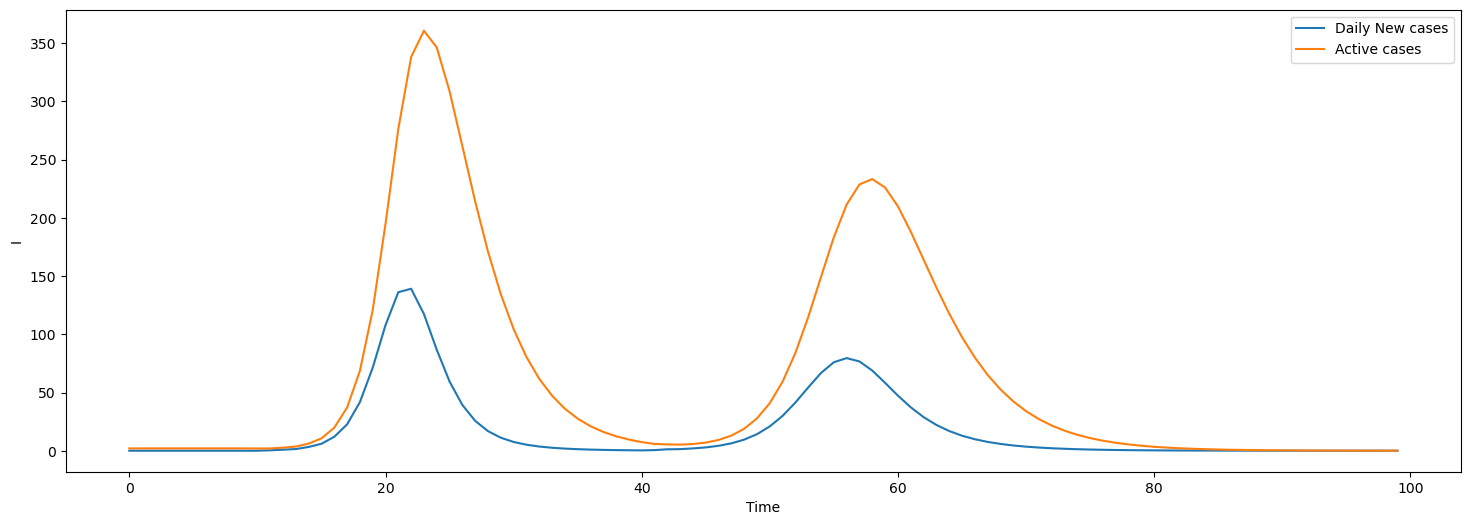

In [223]:
#stateHistoryPlot0= stateHistoryPlot[0, :, 0, :, 0]
#stateHistoryPlot1= stateHistoryPlot[0, :, 1, :, 0]
#stateHistoryPlot2= stateHistoryPlot[0, :, 2, :, 0]

plt.figure(figsize=(18,6))
# plt.plot(stateHistoryPlot0, label=["s0", "e0", "i0", "r0"])
# plt.plot(stateHistoryPlot1, label=["s1", "e1", "i1", "r1"])
# plt.plot(stateHistoryPlot2, label=["s2", "e2", "i2", "r2"])
# for i, _ in enumerate(staticSI):
#     staticSI[i]= i*staticSI[i]
plt.plot(staticNewIPlot, label="Daily New cases")
plt.plot(iTruePlot, label="Active cases")
plt.xlabel("Time")
#plt.ylabel("Infectiveness number")
plt.ylabel("I")
plt.legend()

In [56]:
print(stateHistory.shape)

torch.Size([100, 1, 2, 1000, 4, 1])


In [224]:
from sklearn.mixture import GaussianMixture
import numpy as np
def estimate_days(trueDistribution, timeHorizon, component, sample_size = 1000):
    propotionITrue= trueDistribution.cpu().detach().numpy()
    propotionITrue[propotionITrue < component+0.1] = 0
    propotionITrue= propotionITrue/propotionITrue.sum()
    sampled_points = np.random.choice(timeHorizon, size=sample_size, p=propotionITrue)
    gmm = GaussianMixture(n_components= component)
    gmm.fit(sampled_points.reshape(-1, 1))
    return gmm.means_.flatten()- 3*np.sqrt(gmm.covariances_).flatten()
initDays= estimate_days(staticNewI, timeHorizon, Kn)
print(initDays)

windowSize= 3
batchSize= 60
psF=  torch.tensor([[0.8, 0.2, 0, 0],
                    [0, 0.5, 0.5, 0],
                    [0, 0, 0.9, 0.1],
                    [0, 0, 0, 1]], device=device)
psMtricesF= torch.stack([psF, psF])
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
crossImmMatrixF= torch.tensor([[0, 0.8,  1 ],
                                [0.8, 0, 1],
                                [1, 1, 0]], device=device)
TsF=  torch.tensor(initDays, dtype= torch.float32, device=device)
modelFit= general_EPIs_dense(contact, psMtricesF, crossImmMatrixF, TsF, device= device, train=True)
lossFn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam([{'params': modelFit._Ts, 'lr': 3e-3},
                               {'params': modelFit._psMatrices, 'lr': 1e-3},
                               {'params': modelFit._crossImmMatrix, 'lr': 0},
                               {'params': modelFit._trust, 'lr': 0}], lr=1e-2)
losses= []
days= []
grads= []
alphas= []
mean= 0
var= 0
#alpha= 0.8
timet= 0
bestLoss= 100000
bestPredict= None
sampleGrads= []
print(staticNewI.shape)
print(iTrue.shape)


[13.93807831 42.52189206]
torch.Size([100])
torch.Size([100])


In [225]:
def generate_dateset(model: general_EPIs_dense, ys, timeHorizon=100, windowSize= 5, leastSampleNum= 60, device="cpu"):
    with torch.no_grad():
        statesZero= create_population.general_populations(Kn, n, device=device)# 3, 1000, 4, 1
        init_first_cases(statesZero)
        allStates, _, newI= sim(timeHorizon, model, statesZero, device=device)#generate data more times, 600, 3, 1000, 4, 1
        diffI= torch.abs(newI- ys)
        middleValue= torch.median(diffI)
        meanValue= torch.mean(diffI)
        biggerThanMean= (diffI-meanValue)>0
        biggerThanMeanNum= biggerThanMean.sum()
        thresholdI= middleValue if biggerThanMeanNum< leastSampleNum else meanValue
        infectiveNum= []
        usefulStates= []
        for i in range(timeHorizon-windowSize):
            timesTemp= torch.tensor([j for j in range(i+1, i+windowSize+1)], dtype=torch.float32, device=device)
            embedTemp= torch.stack([ys[i: i+windowSize], timesTemp])# +1 means predict
            if diffI[i]>= thresholdI:
                infectiveNum.append(embedTemp)
                usefulStates.append(allStates[i, ...])
        infectiveNum= torch.stack(infectiveNum)
        usefulStates= torch.stack(usefulStates)
        usefulStates= usefulStates.squeeze(dim=1)
        dataset = torch.utils.data.TensorDataset(usefulStates, infectiveNum)
        return dataset, newI
dataset, newI0= generate_dateset(modelFit, staticNewI, timeHorizon, windowSize, device=device)
#print(allStates.shape)#[97, 2, 1000, 4, 1]


In [226]:
#optimizer = torch.optim.Adam(modelFit.parameters(), lr=1e-2)
staticNewI.requires_grad_(True)
#adaptive 
for i in tqdm(range(500)):
    dataset, newI0= generate_dateset(modelFit, staticNewI, timeHorizon, windowSize, leastSampleNum= batchSize, device=device)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle = True)
    #modelFit._trust= alpha
    #with torch.autograd.set_detect_anomaly(True):
    for batch in dataloader:
        optimizer.zero_grad()
        fitY= []
        x, y = batch
        yT= y[:, 0, :]
        timesT= y[:, 1, :]
        x=[x]
        for j in range(windowSize):
            t= timesT[:, j:j+1]
            stateNew, newIt = modelFit(x[-1], t)
            prob0= 1-newIt[:, 0, :]
            prob1= 1-newIt[:, 1, :]
            #prob2= 1-stateNew[:, 2, :, 2, 0]
            statisticI= 1-prob0*prob1#*prob2
            fitY.append(statisticI.sum(dim=1))
            x.append(stateNew)
        yT= yT.T
        fitY= torch.stack(fitY)
        loss= lossFn(fitY, yT)
        losses.append(loss.item())
        loss.backward(retain_graph=True)
        #gradient clipping
        #clip_value= 100.0
        parameters = [param for param in modelFit.parameters() if param.grad is not None]
        gradients = torch.cat([param.grad.view(-1) for param in parameters])
        total_norm = torch.norm(gradients)
        if(torch.isnan(total_norm)):
            print("NAN LOSS")
            continue
        # if total_norm > clip_value:
        #     scale_factor = clip_value / total_norm
        #     for param in parameters:
        #         param.grad.data.mul_(scale_factor)
        #adaptive
        days.append([modelFit._Ts[0,0].item(), modelFit._Ts[0,1].item()])
        gradTs = torch.autograd.grad(loss, modelFit._sampleT)
        gradTs = gradTs[0].sum(dim=0)/batchSize
        sampleGrads.append(gradTs)
        gradT= gradTs
        beta1= 0.99
        beta2= 0.99
        beta3= 0.05
        mean= beta1*mean+ (1-beta1)*gradT
        var= beta2*var+(1-beta2)*gradT**2
        m_hat = mean / (1 - beta1**(timet+1))
        v_hat = var / (1 - beta2**(timet+1))
        timet+=1
        #alphaNew= torch.sqrt(v_hat)/(torch.abs(m_hat)+1e-5)*0.1
        #alphaNew= 1/((1-beta3)*torch.abs(m_hat)+beta3*torch.sqrt(v_hat))
        if m_hat.abs().sum()<0.1:
            m_hat= m_hat*0+ 40
            alpha= alpha*1.2
            if alpha>10:
                alpha= 10
        alpha= 1
        alphas.append(alpha)
        grads.append(gradT)
        optimizer.step()
        if loss.item()<= bestLoss:
            bestLoss= loss.item()
            bestPredict= newI0.cpu().detach()
        break


 74%|███████▍  | 372/500 [01:01<00:20,  6.35it/s]

In [215]:
print(modelFit._Ts)
print(modelFit._trust)
print(m_hat)

Parameter containing:
tensor([[11.3064, 43.1005]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-1., -1.]], device='cuda:0', requires_grad=True)
tensor([0.1069, 2.5822], device='cuda:0')


Text(0, 0.5, 'epoches')

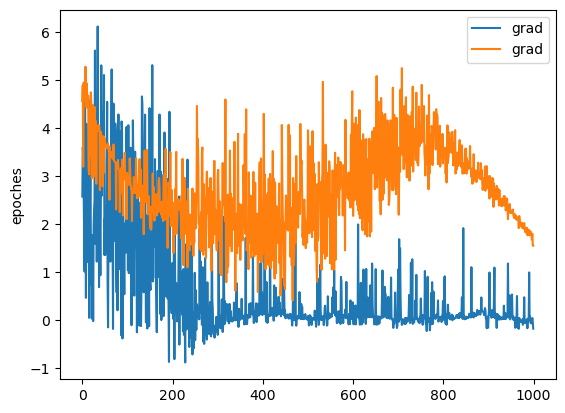

In [216]:
sampleGradsTensor= torch.stack(sampleGrads)
plotSampleGrads= sampleGradsTensor.cpu().detach()
plt.plot(plotSampleGrads, label= "grad")
plt.legend()
plt.ylabel("epoches")
#plt.yscale("log")

In [75]:
alphasTensor= torch.stack(alphas).cpu().squeeze().detach()
plt.plot(alphasTensor[0:, :], label=["alpha0", "alpha1"])
print(alphasTensor[-1, :])
plt.yscale("log")
plt.legend()
plt.xlabel("epoches")
plt.ylabel("a")

TypeError: expected Tensor as element 0 in argument 0, but got int

[11.306419372558594, 43.10063934326172]


Text(0.5, 0, 'epoches')

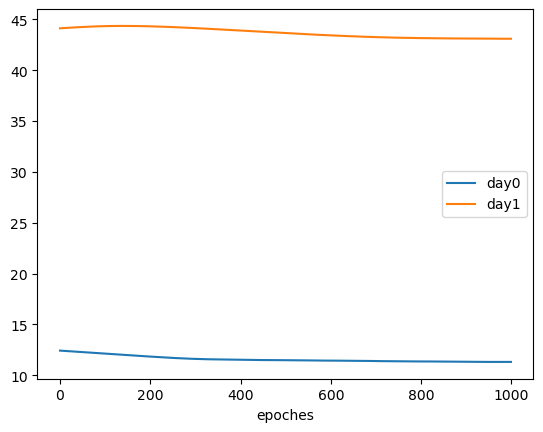

In [217]:
#print(grads)
#plt.plot(grads, label="grad")
plt.plot(days, label=["day0", "day1"])
print(days[-1])
plt.legend()
plt.xlabel("epoches")
#plt.yscale("log")


Parameter containing:
tensor([[11.3064, 43.1005]], device='cuda:0', requires_grad=True)


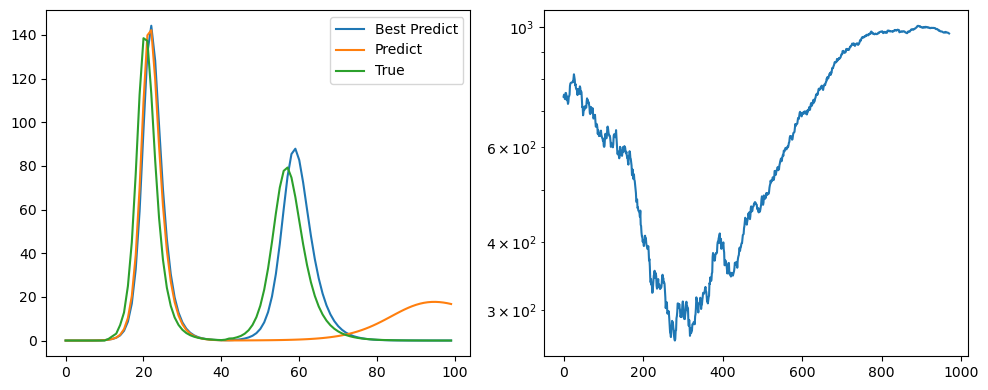

In [218]:
print(modelFit._Ts)
newI0Plot= newI0.cpu().detach()
bestPlot= bestPredict

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


# Plot the first sub-figure
ax1.plot(bestPlot, label="Best Predict")
ax1.plot(newI0Plot, label="Predict")
ax1.plot(staticNewIPlot, label="True")
ax1.legend()
# Plot the second sub-figure
winSize= 30
window = np.ones(winSize) / winSize
y_avg = np.convolve(losses, window, mode='valid') 
ax2.plot(y_avg)
ax2.set_yscale("log")
# Adjust the spacing between sub-plots
plt.tight_layout()
# Show the plot
plt.show()

In [194]:
print(loss)
print(modelFit._mysoftmax(modelFit._psMatrices+modelFit._mask1))
def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')
print_model_parameters(modelFit)

tensor(102.8894, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([[[2.5317e-01, 7.4683e-01, 9.8091e-45, 9.8091e-45],
         [9.8091e-45, 7.1800e-01, 2.8200e-01, 9.8091e-45],
         [5.6052e-45, 5.6052e-45, 9.4590e-01, 5.4102e-02],
         [1.4013e-44, 1.4013e-44, 1.4013e-44, 1.0000e+00]],

        [[9.7047e-02, 9.0295e-01, 7.0065e-45, 7.0065e-45],
         [7.0065e-45, 8.9180e-01, 1.0820e-01, 7.0065e-45],
         [4.2039e-45, 4.2039e-45, 9.7104e-01, 2.8960e-02],
         [1.4013e-44, 1.4013e-44, 1.4013e-44, 1.0000e+00]]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
name           : _psMatrices
parameter      : Parameter containing:
tensor([[[-4.0893e-02,  1.0409e+00,  2.5635e-33, -3.3064e-35],
         [ 3.1986e-34,  9.6728e-01,  3.2719e-02,  3.3331e-34],
         [-1.1213e-34, -1.2256e-33,  1.9306e+00, -9.3063e-01],
         [-1.5450e-34, -1.4922e-32, -5.5174e-35,  1.0000e+00]],

        [[-6.1524e-01,  1.6152e+00,  1.9957e-34, -2.6725e-36],
         [ 3.8712e-34,  1